In [3]:
from classes import *
import time
import matplotlib
from optparse import OptionParser

from itertools import product
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
wt_sq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [4]:
num_iter = 1
mse_train = []
mse_val = []

In [69]:
n = 1
num_scales, block_repeats, weight_decay, keep_prob = choose_parameters_combination(n)
mode = 'gpu'
n_epoch = 200
kernel_size = 3
pool_size = 3

timestr = time.strftime("%Y%m%d-%H%M")
log_dir = '../models/' + timestr + '/'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

f = '../data/amino_acid_genotypes_to_brightness.txt'
batch_size, zero_sample_fraction = 100, 0.5
input_data = Data(file_path=f, batch_size=batch_size, zero_sample_fraction=zero_sample_fraction, zeroing=True)

In [70]:
for it in range(num_iter):

    print('ITERATION #', it)

    input_data.train_test_split()

    NN_name = 'ResNet' + str(num_scales) + '_' + str(batch_size)
    NN_id = "S%dB%d_WD%.2fDO%.2f" % (num_scales, block_repeats, weight_decay, keep_prob)

    reset_graph()
    try:
        nn_instance = ResNet(input_data, num_scales, block_repeats, NN_name, mode,
                             kernel_size, pool_size, weight_decay, keep_prob, n_epoch)

        train_mse_hist, val_mse_hist = train_NN(nn_instance, input_data, 20, log_dir, NN_id)

        mse_train.append(train_mse_hist[-1])
        mse_val.append(val_mse_hist[-1])

    except:
        mse_train.append(0)
        mse_val.append(0)

    if it == 0:
        print('Generating data for prediction')
        input_df = make_data_for_prediction(input_data)
        recording_predictions = np.zeros(shape=[len(input_df), num_iter])

    print('Restoring session for prediction')
    with tf.Session() as sess:

        saver = tf.train.Saver()
        saver.restore(sess, log_dir + "model_" + NN_id + ".ckpt")

        predictions_val = [sess.run(nn_instance.preds_val, {nn_instance.x_val_ph: input_data.x_val}) for _ in range(100)]

('ITERATION #', 0)
Initializing NN
Epoch #			Train MSE		Test MSE
0			4.11			3.80
10			2.82			2.78
20			1.38			1.37
30			0.85			0.88
40			0.64			0.69
50			0.58			0.61
60			0.53			0.57
70			0.49			0.58
80			0.46			0.53
90			0.46			0.53
100			0.43			0.56
Generating data for prediction
Restoring session for prediction
INFO:tensorflow:Restoring parameters from ../models/20180515-1501/model_S2B3_WD0.10DO0.50.ckpt


In [71]:
predictions_val=np.array(predictions_val).swapaxes(1,0)
predictions_df = pd.DataFrame(index=[x for x in range(100)])

for i,col in enumerate(predictions_val):
    predictions_df[i]=col
    
predictions_summary=predictions_df.describe()

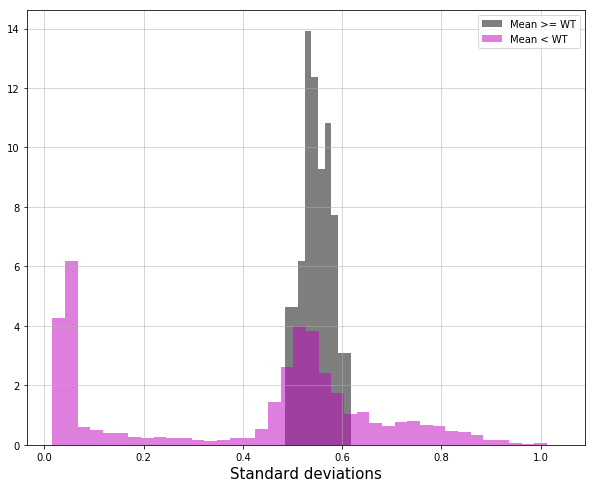

In [74]:
test1=predictions_summary[[column for column in predictions_summary.columns if predictions_summary.loc['mean'][column]>=3.72]]
test2=predictions_summary[[column for column in predictions_summary.columns if predictions_summary.loc['mean'][column]<3.72]]
plt.figure(figsize=[10,8])
plt.hist(test1.loc['std'],bins=10,alpha=0.5,color='k',normed=True,label='Mean >= WT')
plt.hist(test2.loc['std'],bins=40,alpha=0.5,color='m',normed=True,label='Mean < WT')
plt.grid('--',lw=0.5)
plt.legend()
plt.xlabel('Standard deviations',fontsize=15)
plt.savefig('../figures/uncertainty/' + timestr + '_' + '_std_hist_' + str(n) + '.pdf')

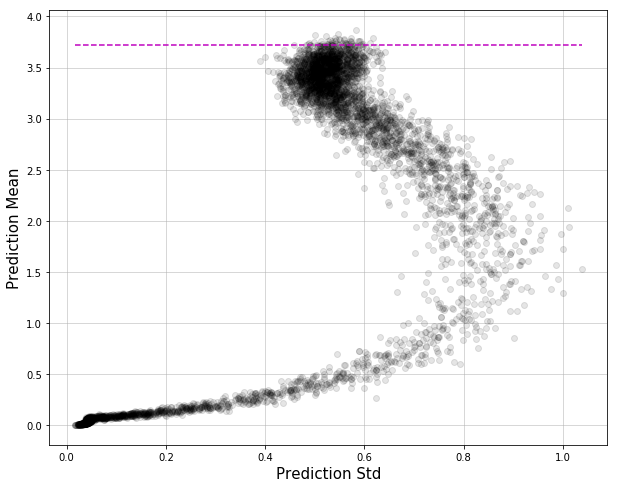

In [83]:
plt.figure(figsize=[10,8])
plt.plot(predictions_summary.loc['std'],predictions_summary.loc['mean'],'ok',alpha=0.1)
plt.grid('--',lw=0.5)
plt.xlabel('Prediction Std',fontsize=15)
plt.ylabel('Prediction Mean',fontsize=15)
plt.plot([min(predictions_summary.loc['std']),max(predictions_summary.loc['std'])],[3.72]*2,'--m')
plt.savefig('../figures/uncertainty/' + timestr + '_' + '_std_mean_' + str(n) + '.pdf')